<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP
# Notebook 3 - Modeling and Conclusion

In [1]:
# import libraries

import pandas as pd
from pycaret.classification import *
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from pycaret.utils import check_metric

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [3]:
drinks = pd.read_csv('../datasets/drinks.csv')

In [4]:
drinks.isnull().sum() # null values after importing csv

subreddit           0
post_processed    102
dtype: int64

In [5]:
drinks.dropna(inplace = True) # drop null values
drinks = drinks.reset_index(drop = True) # reset index of dataset
drinks.rename({'subreddit': 'is_tea'}, inplace = True, axis = 1)

In [6]:
drinks.isnull().sum() # check that there's no null values

is_tea            0
post_processed    0
dtype: int64

In [7]:
drinks.shape

(25063, 2)

In [8]:
drinks['is_tea'].value_counts(normalize = True)

0    0.53166
1    0.46834
Name: is_tea, dtype: float64

From the above cell, we can see that the distribution of the target variable is relatively balanced with almost an equal number of 'Coffee' and 'tea' rows. 

## Modeling
Now that we have cleaned up the data that was scraped, we will look into modeling to find the best model to use. <br>
Here are the steps we will follow to find the best model: 
1. Setup a Baseline Model
2. Setup pyCaret to compare and identify models for further evaluation
3. Create and tune hyperparameters for the selected models in Step 2
4. Evaluate and select the best model

### Step 1 - Setup a Baseline Model

Given that this is a binary classification problem (coffee vs tea), we will build a simple baseline model using <b>Multinomial Naive Bayes</b>.<br>
The documentation on Multinomial Naive Bayes states that "the multinomial distribution normally requires an integer feature count. However, in practice, fractional counts such as tf-idf may also work." [<sup>[1]</sup>](#References) <br>Hence, we will be using TF-IDF throughout this notebook as TF-IDF is a more robust vectorizer since it takes into account not only how many times a word appears in a document, but also how important that word is in the corpus as a whole. 

In [9]:
X = drinks['post_processed']
y = drinks['is_tea'] # 0 == coffee, 1 == tea

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y) # train-test split

In [11]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()), # instatntiate a CountVectorize with default parameters
    ('nb', MultinomialNB()) # instantiate the model
])

In [12]:
pipe.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'nb': MultinomialNB(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [13]:
pipe_params = {'tvec__max_features': [None, 1000, 2000],
            'tvec__min_df': [0.001, 0.005, 0.01],
            'tvec__ngram_range': [(1, 1), (2, 2), (3,3), (1, 3)]}

In [14]:
pipe_gridsearch = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)

In [15]:
pipe_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [None, 1000, 2000],
                         'tvec__min_df': [0.001, 0.005, 0.01],
                         'tvec__ngram_range': [(1, 1), (2, 2), (3, 3), (1, 3)]})

In [16]:
pipe_gridsearch.best_params_

{'tvec__max_features': None,
 'tvec__min_df': 0.001,
 'tvec__ngram_range': (1, 3)}

In [17]:
pd.DataFrame(pipe_gridsearch.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tvec__max_features,param_tvec__min_df,param_tvec__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.807909,0.013430,0.117554,0.008064,None,0.001,"(1, 3)","{'tvec__max_features': None, 'tvec__min_df': 0.001, 'tvec__ngram_range': (1, 3)}",0.876309,0.876309,0.873067,0.877556,0.876060,0.875860,0.001491,1
0,0.182573,0.002447,0.042549,0.000200,None,0.001,"(1, 1)","{'tvec__max_features': None, 'tvec__min_df': 0.001, 'tvec__ngram_range': (1, 1)}",0.873317,0.876060,0.869077,0.874813,0.878055,0.874264,0.003023,2
24,0.195240,0.003292,0.046051,0.000578,2000,0.001,"(1, 1)","{'tvec__max_features': 2000, 'tvec__min_df': 0.001, 'tvec__ngram_range': (1, 1)}",0.867830,0.873067,0.869327,0.874065,0.872569,0.871372,0.002378,3
27,1.699870,0.011307,0.115169,0.000634,2000,0.001,"(1, 3)","{'tvec__max_features': 2000, 'tvec__min_df': 0.001, 'tvec__ngram_range': (1, 3)}",0.870075,0.872818,0.866334,0.873815,0.872070,0.871022,0.002646,4
15,1.725264,0.033501,0.113939,0.000712,1000,0.001,"(1, 3)","{'tvec__max_features': 1000, 'tvec__min_df': 0.001, 'tvec__ngram_range': (1, 3)}",0.846135,0.847132,0.849127,0.847880,0.853117,0.848678,0.002425,5


In [18]:
pipe_gridsearch.best_score_

0.875860349127182

In [19]:
pipe_gridsearch.score(X_train, y_train)

0.8956109725685786

In [20]:
pipe_gridsearch.score(X_test, y_test)

0.8715340115699182

In [21]:
y_pred = pipe_gridsearch.predict(X_test)

In [22]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[2382,  283],
       [ 361, 1987]])

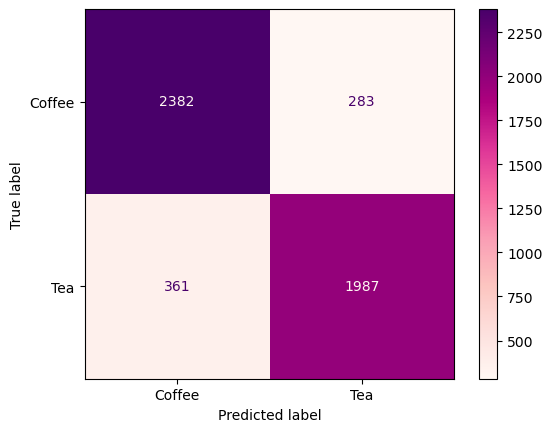

In [23]:
plot_confusion_matrix(pipe_gridsearch, X_test, y_test, cmap='RdPu', display_labels = ['Coffee', 'Tea']);

We can conclude that the baseline model is approximately 87.2% accurate.<br> 
However, given that the model performs slightly better when cross-validated on training data then the test data (0.8956 vs 0.8715), there may be slight overfitting. 

### Step 2 - Setup pyCaret to compare and identify models for further evaluation

Similar to Step 1, we will run the corpus through a TF-IDF vectorizer first before running PyCaret to compare and pick the top 3 models. 

In [24]:
# Instantiate and Vectorize

tvec = TfidfVectorizer(ngram_range=(1,3), min_df = 0.001)
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

X_train_tvec = pd.DataFrame(X_train_tvec.toarray(), columns = tvec.get_feature_names())
X_test_tvec = pd.DataFrame(X_test_tvec.toarray(), columns = tvec.get_feature_names())

In [25]:
train_pycaret = pd.concat([X_train_tvec, y_train.reset_index(drop = True)], axis = 1)
test_pycaret = pd.concat([X_test_tvec, y_test.reset_index(drop = True)], axis = 1)

In [26]:
print(f'Train dataset: {train_pycaret.shape}')
print(f'Test dataset: {test_pycaret.shape}')

Train dataset: (20050, 3733)
Test dataset: (5013, 3733)


In [27]:
pycaret_setup = setup(data = train_pycaret, target = 'is_tea', fold = 5, use_gpu = True, preprocess = False, session_id = 42)

,Description,Value
0,session_id,42
1,Target,is_tea
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(20050, 3733)"
5,Missing Values,False
6,Numeric Features,3732
7,Categorical Features,0
8,Transformed Train Set,"(14034, 3732)"
9,Transformed Test Set,"(6016, 3732)"


In [28]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8820,0.9594,0.8826,0.8670,0.8746,0.7632,0.7635,1.2180
svm,SVM - Linear Kernel,0.8763,0.0000,0.8800,0.8587,0.8689,0.7519,0.7526,1.7760
et,Extra Trees Classifier,0.8733,0.9424,0.8588,0.8682,0.8634,0.7453,0.7454,8.3560
lightgbm,Light Gradient Boosting Machine,0.8689,0.9544,0.9104,0.8263,0.8662,0.7383,0.7418,1.4620
ridge,Ridge Classifier,0.8681,0.0000,0.8614,0.8567,0.8589,0.7351,0.7353,1.4780
rf,Random Forest Classifier,0.8655,0.9443,0.8719,0.8448,0.8580,0.7303,0.7308,5.0800
dt,Decision Tree Classifier,0.8335,0.8426,0.8320,0.8150,0.8233,0.6660,0.6663,10.8880
lda,Linear Discriminant Analysis,0.8298,0.9108,0.8338,0.8076,0.8204,0.6588,0.6593,30.1720
gbc,Gradient Boosting Classifier,0.8157,0.9211,0.9636,0.7287,0.8298,0.6372,0.6672,31.1860
nb,Naive Bayes,0.8149,0.8257,0.9285,0.7406,0.8239,0.6341,0.6523,0.4440


Models that we will evaluate are: 
1. Logistic Regression
2. SVM - Linear Kernel
3. Light Gradient Boosting Machine
4. Random Forest Classifier

Extra Trees Classifier and Random Forest Classifier very similar as both are a collection of decision trees. However, Extra Trees Classifier does not bootstrap samples and their nodes are split based on a random value that is selected for every split which results in a low variance but high biasness. Hence we will evaluate Random Forest Classifier instead. 

Light Gradient Boosting Machine is added to the list so as to explore the effects of gradient boosting. 

### Step 3 - Create and tune hyperparameters for the selected models in Step 2

#### Logistic Regression

In [29]:
lr = create_model('lr') # train model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8789,0.9592,0.8694,0.8707,0.8700,0.7566,0.7566
1,0.8839,0.9588,0.9022,0.8564,0.8787,0.7675,0.7684
2,0.8792,0.9572,0.8792,0.8640,0.8715,0.7576,0.7577
3,0.8881,0.9614,0.8700,0.8877,0.8788,0.7749,0.7751
4,0.8799,0.9602,0.8922,0.8562,0.8738,0.7593,0.7599
Mean,0.8820,0.9594,0.8826,0.8670,0.8746,0.7632,0.7635
SD,0.0035,0.0014,0.0128,0.0117,0.0036,0.0070,0.0071


In [30]:
tuned_lr = tune_model(lr, choose_better=True) # tune model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8764,0.9584,0.8869,0.8537,0.8700,0.7522,0.7527
1,0.8846,0.9590,0.9160,0.8485,0.8810,0.7693,0.7714
2,0.8778,0.9575,0.8861,0.8566,0.8711,0.7550,0.7554
3,0.8878,0.9611,0.8853,0.8753,0.8803,0.7747,0.7747
4,0.8820,0.9602,0.9067,0.8502,0.8775,0.7640,0.7655
Mean,0.8817,0.9592,0.8962,0.8569,0.8760,0.7630,0.7639
SD,0.0042,0.0013,0.0127,0.0096,0.0046,0.0084,0.0086


In [31]:
predict_model(tuned_lr) # predict model

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8840,0.9606,0.8799,0.8756,0.8778,0.7674,0.7674


,aa,ab,ability,able,absolute,absolutely,ac,acceptable,access,accessible,...,yunnansourcing,zero,zpresso,zpresso jx,zpresso jx pro,zpresso max,zpresso plus,is_tea,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9055
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9272
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9771
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.6772
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.7051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113432,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.6657
6012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.7080
6013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9827
6014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.7704


#### SVM - Linear Kernel

In [32]:
svm = create_model('svm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8728,0.0000,0.8633,0.8639,0.8636,0.7445,0.7445
1,0.8771,0.0000,0.8999,0.8463,0.8723,0.7541,0.7554
2,0.8728,0.0000,0.8700,0.8589,0.8644,0.7447,0.7447
3,0.8785,0.0000,0.8563,0.8798,0.8679,0.7555,0.7557
4,0.8803,0.0000,0.9106,0.8447,0.8764,0.7606,0.7626
Mean,0.8763,0.0000,0.8800,0.8587,0.8689,0.7519,0.7526
SD,0.0030,0.0000,0.0213,0.0128,0.0048,0.0063,0.0070


In [33]:
tuned_svm = tune_model(svm, choose_better=True) # tune model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8725,0.0000,0.8464,0.8759,0.8609,0.7432,0.7436
1,0.8707,0.0000,0.8564,0.8650,0.8607,0.7400,0.7401
2,0.8732,0.0000,0.8402,0.8820,0.8606,0.7444,0.7451
3,0.8717,0.0000,0.8303,0.8873,0.8578,0.7412,0.7426
4,0.8753,0.0000,0.8524,0.8766,0.8643,0.7489,0.7492
Mean,0.8727,0.0000,0.8452,0.8773,0.8609,0.7436,0.7441
SD,0.0015,0.0000,0.0092,0.0074,0.0021,0.0031,0.0030


In [34]:
predict_model(tuned_svm) # predict model 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.8634,0.8678,0.9505,0.7990,0.8682,0.7286,0.7404


,aa,ab,ability,able,absolute,absolutely,ac,acceptable,access,accessible,...,yunnan sourcing,yunnansourcing,zero,zpresso,zpresso jx,zpresso jx pro,zpresso max,zpresso plus,is_tea,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113432,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1
6012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1
6013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
6014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1


#### Light Gradient Boostin Machine

In [35]:
lightgbm = create_model('lightgbm') # train model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8710,0.9551,0.9114,0.8290,0.8683,0.7425,0.7457
1,0.8671,0.9527,0.9175,0.8192,0.8656,0.7350,0.7396
2,0.8646,0.9540,0.9098,0.8196,0.8623,0.7299,0.7337
3,0.8764,0.9575,0.8968,0.8469,0.8711,0.7525,0.7537
4,0.8653,0.9526,0.9167,0.8168,0.8638,0.7314,0.7362
Mean,0.8689,0.9544,0.9104,0.8263,0.8662,0.7383,0.7418
SD,0.0044,0.0018,0.0074,0.0111,0.0032,0.0084,0.0072


In [36]:
tuned_lightgbm = tune_model(lightgbm, choose_better=True) # tune model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8671,0.9517,0.8892,0.8362,0.8619,0.7341,0.7354
1,0.8611,0.9504,0.8961,0.8220,0.8575,0.7224,0.7250
2,0.8600,0.9487,0.8884,0.8247,0.8554,0.7201,0.7219
3,0.8735,0.9537,0.8815,0.8522,0.8666,0.7464,0.7468
4,0.8574,0.9480,0.8976,0.8153,0.8544,0.7154,0.7186
Mean,0.8638,0.9505,0.8906,0.8301,0.8591,0.7277,0.7295
SD,0.0058,0.0021,0.0058,0.0130,0.0045,0.0112,0.0103


In [37]:
predict_model(tuned_lightgbm) # predict model 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8782,0.9581,0.9136,0.8423,0.8765,0.7567,0.7591


,aa,ab,ability,able,absolute,absolutely,ac,acceptable,access,accessible,...,yunnansourcing,zero,zpresso,zpresso jx,zpresso jx pro,zpresso max,zpresso plus,is_tea,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9186
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9614
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9480
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.7100
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.8157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113432,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.9385
6012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.7429
6013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9989
6014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.7883


#### Random Forest Classifier

In [38]:
rf = create_model('rf') # create model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8689,0.9473,0.8686,0.8530,0.8607,0.7369,0.7370
1,0.8607,0.9413,0.8846,0.8283,0.8556,0.7213,0.7228
2,0.8600,0.9396,0.8693,0.8366,0.8526,0.7194,0.7199
3,0.8746,0.9478,0.8647,0.8660,0.8653,0.7480,0.7480
4,0.8632,0.9455,0.8723,0.8402,0.8560,0.7257,0.7262
Mean,0.8655,0.9443,0.8719,0.8448,0.8580,0.7303,0.7308
SD,0.0055,0.0033,0.0068,0.0132,0.0045,0.0108,0.0104


In [39]:
tuned_rf = tune_model(rf, choose_better=True) # tune model

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8244,0.9324,0.9465,0.7455,0.8341,0.6530,0.6742
1,0.8269,0.9302,0.9473,0.7483,0.8361,0.6579,0.6786
2,0.8219,0.9278,0.9327,0.7475,0.8299,0.6477,0.6652
3,0.8368,0.9357,0.9235,0.7714,0.8406,0.6762,0.6878
4,0.8204,0.9263,0.9358,0.7445,0.8293,0.6449,0.6638
Mean,0.8261,0.9305,0.9372,0.7515,0.8340,0.6559,0.6739
SD,0.0058,0.0033,0.0089,0.0101,0.0042,0.0111,0.0089


In [40]:
predict_model(tuned_rf) # predict model by validating against validation set

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8715,0.9485,0.8697,0.8604,0.8650,0.7424,0.7425


,aa,ab,ability,able,absolute,absolutely,ac,acceptable,access,accessible,...,yunnansourcing,zero,zpresso,zpresso jx,zpresso jx pro,zpresso max,zpresso plus,is_tea,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9400
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.8900
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9300
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.6772
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.7000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113432,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,0,0.5800
6012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.5209
6013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9900
6014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.6832


|Model|Logistic Regression|SVM - Linear Kernel|Light Gradient Boosting Machine|Random Forest Classifier|
|---|---|---|---|---|
|Validation score|0.8840|0.8634|0.8782|0.8715|

Logistic Regression model has the best score at 0.884.<br>
Given that the validation scores are pretty close to each other. We will train the models with the entire train dataset to compare the prediction with the test dataset to determine which model has a higher accuracy.

In [41]:
# Train model on the complete dataset
final_lr = finalize_model(tuned_lr)

In [42]:
final_svm = finalize_model(tuned_svm)

In [43]:
final_lightgbm = finalize_model(tuned_lightgbm)

In [44]:
final_rf = finalize_model(tuned_rf)

In [45]:
predict_model(final_lr)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9207,0.9780,0.9238,0.9101,0.9169,0.8411,0.8412


,aa,ab,ability,able,absolute,absolutely,ac,acceptable,access,accessible,...,yunnansourcing,zero,zpresso,zpresso jx,zpresso jx pro,zpresso max,zpresso plus,is_tea,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9311
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9152
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9865
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.7325
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.7672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113432,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.6798
6012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.7664
6013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9867
6014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.8689


In [46]:
predict_model(final_svm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.9166,0.9164,0.9136,0.9104,0.9120,0.8327,0.8327


,aa,ab,ability,able,absolute,absolutely,ac,acceptable,access,accessible,...,yunnan sourcing,yunnansourcing,zero,zpresso,zpresso jx,zpresso jx pro,zpresso max,zpresso plus,is_tea,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113432,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1
6012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1
6013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
6014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1


In [47]:
predict_model(final_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9067,0.9776,0.9505,0.8657,0.9061,0.8139,0.8174


,aa,ab,ability,able,absolute,absolutely,ac,acceptable,access,accessible,...,yunnansourcing,zero,zpresso,zpresso jx,zpresso jx pro,zpresso max,zpresso plus,is_tea,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9166
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9489
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9709
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.7644
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.8507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113432,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.9623
6012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.7936
6013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9981
6014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.9027


In [48]:
predict_model(final_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9880,0.9996,0.9930,0.9819,0.9874,0.9760,0.9761


,aa,ab,ability,able,absolute,absolutely,ac,acceptable,access,accessible,...,yunnansourcing,zero,zpresso,zpresso jx,zpresso jx pro,zpresso max,zpresso plus,is_tea,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9700
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9700
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9800
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.8955
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.9300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113432,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.8500
6012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.8350
6013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9900
6014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.8734


In [49]:
pred_lr = predict_model(final_lr, data = test_pycaret)

In [50]:
pred_svm = predict_model(final_svm, data = test_pycaret)

In [51]:
pred_lightgbm = predict_model(final_lightgbm, data = test_pycaret)

In [52]:
pred_rf = predict_model(final_rf, data = test_pycaret)

In [53]:
check_metric(pred_lr['is_tea'], pred_lr['Label'], metric = 'Accuracy')

0.8835

In [54]:
check_metric(pred_svm['is_tea'], pred_svm['Label'], metric = 'Accuracy')

0.8803

In [55]:
check_metric(pred_lightgbm['is_tea'], pred_lightgbm['Label'], metric = 'Accuracy')

0.8741

In [56]:
check_metric(pred_rf['is_tea'], pred_rf['Label'], metric = 'Accuracy')

0.8735

### Step 4 - Evaluate and select the best model

|Model|Multinomial Naive Bayes (Baseline)|Logistic Regression|SVM - Linear kernel|Light Gradient Boosting Machine|Random Forest Classifier|
|---|---|---|---|---|---|
|Train score|0.8956|0.9207|0.9166|0.9067|0.9880|
|Test score|0.8715|0.8835|0.8803|0.8741|0.8735|

We can observe that the 4 models evaluated have higher train and test scores compared to the baseline model. <br>
Given that the train score is slightly higher than the test score for Logistic Regression, SVM - Linear kernel and Light Gradient Boosting Machine, it may indicate a slight overfitting of the model. Random Forest Classifier shows more severe signs of overfitting as the train score is significantly higher than the test score. <br><br>
Overall, Logistic Regression is the best model as it has the highest accuracy score of 0.8835. This means that 88.4% of future posts are likely to be classified correctly by this model.

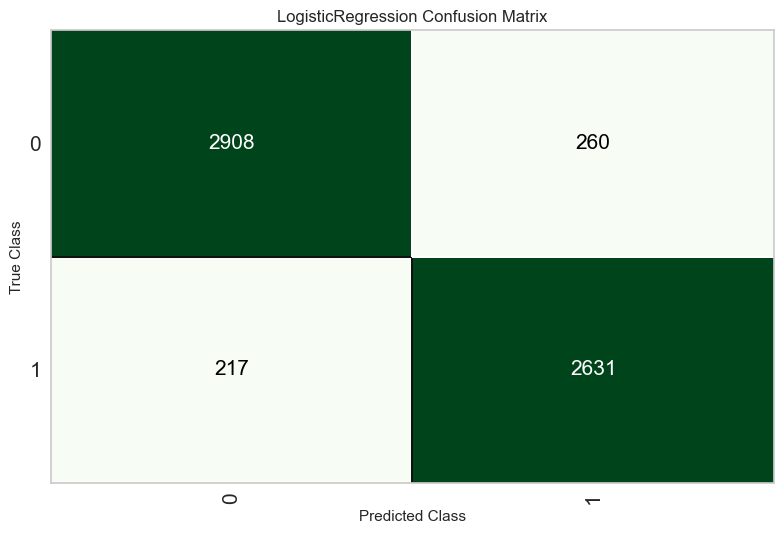

In [57]:
plot_model(final_lr, plot = 'confusion_matrix', plot_kwargs: {'precent': True})

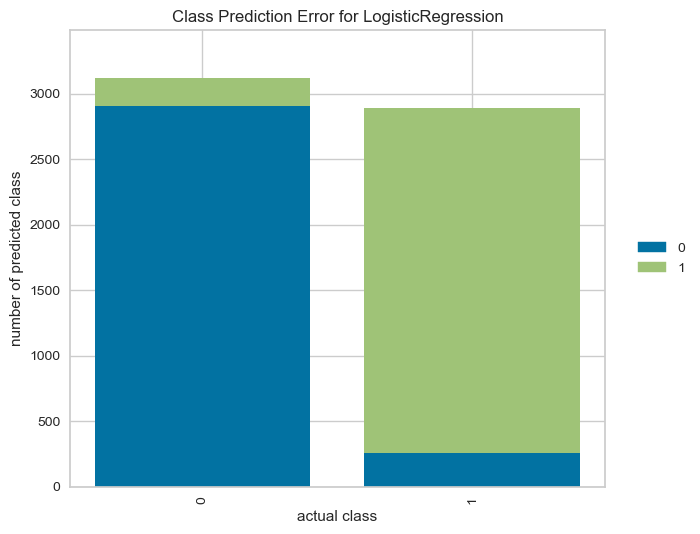

In [58]:
plot_model(final_lr, plot = 'error')

From the confusion matrix and class prediction error plots above, we can observe that the model is better at predicting coffee (class 0) than tea.

In [59]:
final_lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

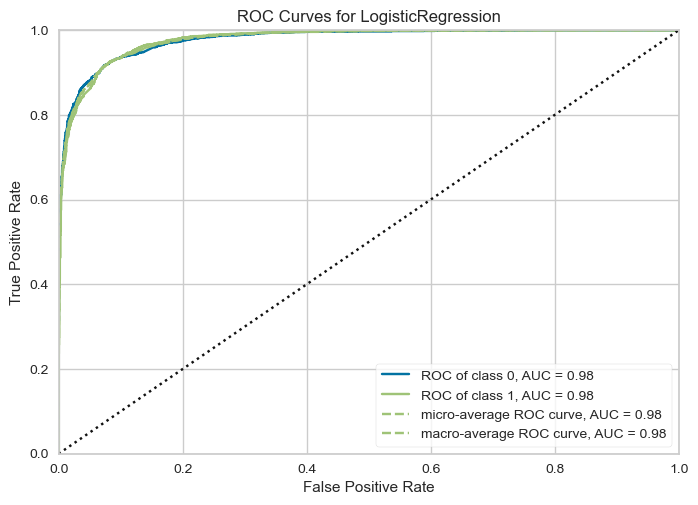

In [60]:
plot_model(final_lr, plot = 'auc')

AUC measures the ability of the Logistic regression model to distinguish between coffee and tea classes. Since AUC value is 0.98, there is a high chance that the classifier is able to dinstinguish between the two classes. 

## Conclusion

Through modeling and hyperparameter tuning above, we can conclude that Logistic regression is the best model with 88% accuracy. However, it is important to note that logistic regression makes the assumption that observations in the dataset are independent of each other. This assumption may not hold true in the real world scenario as words may be dependent on each other due to the nature of languages.

Most Reddit users are from USA. In a study done between Dec'21 - May'22, almost 50% of desktop traffic originates from USA, followed by ~7% from UK as well as Canada.[<sup>[2]</sup>](#References) This shows that Reddit is not very popular among Singaporeans. Hence we can take the results from this analysis as a baseline, but we should also gather localised data for more accurate analysis on local preferences.

## Recommendation
Since we now have a classification model capable of segregating texts into 'Coffee' and 'Tea', we can work towards broaden the dataset and improving accuracy of the model by collecting more data. This can be done by increasing the number of reddit submissions scrapped and expanding the coverage to more platforms, especially ones that are highly used by Singaporeans such as quora, facebook, instagram, twitter etc.

With the trained model, we can also explore other subreddits and categories such as Coffeebean, Starbucks etc. Posts from these categories can be run through our model to classify them before conducting further analysis to filter our most popular flavour profiles and drinks. 

We also recommend: 
- Adding more stopwords to the list of stopwords, to filter out the noise in the dataset 
- Explore Gensim package to gather more topics for analysis
- Expand the model to other relevant topics related to setting up a cafe (eg. interior design of cafe, food menu, equipment for brewing drinks etc)
- Run sentiment analysis on top words verified in ngrams to gather human emotion towards our planned cafe setup

## References
<sup>1</sup> https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB<br>
<sup>2</sup> https://www.google.com/url?q=https://www.statista.com/statistics/325144/reddit-global-active-user-distribution/&sa=D&source=editors&ust=1665561748586934&usg=AOvVaw016E0b4h4Z6XkgRD4_ROvu